In [21]:
#ライブラリのインストール
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [22]:
#geolifeデータセットからpandasへの読込関数
def read_geolife_plt(path):
    cols = ['lat', 'lon', 'unused', 'alt', 'days', 'date', 'time']
    df = pd.read_csv(path, skiprows=6, header=None, names=cols)

    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
    df = df[['lat', 'lon', 'datetime']]
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

In [23]:
#簡易OD分析　緯度経度をゾーンに変換
def to_zone(lat, lon, precision=2):
    """
    precision=2 → 小数点2桁で丸め → 約1km 四方のグリッド
    """
    return (round(lat, precision), round(lon, precision))

In [24]:
#ODペア抽出
def make_od_pairs(df, precision=2):
    df['zone'] = df.apply(lambda r: to_zone(r['lat'], r['lon'], precision), axis=1)

    # 連続ペア
    df['zone_next'] = df['zone'].shift(-1)

    # 最後の行は不要
    od_df = df.dropna(subset=['zone_next']).copy()

    # OD マトリクス化用
    od_pairs = od_df.groupby(['zone', 'zone_next']).size().reset_index(name='count')

    return od_pairs

In [28]:
#一つのデータでODペアを検出してみる
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Geolife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"

df = read_geolife_plt(path)
od_pairs = make_od_pairs(df, precision=2)

od_pairs.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,zone,zone_next,count
0,"(39.98, 116.3)","(39.98, 116.3)",123
1,"(39.98, 116.3)","(39.99, 116.3)",2
2,"(39.98, 116.3)","(40.0, 116.29)",1
3,"(39.98, 116.31)","(39.98, 116.3)",1
4,"(39.98, 116.31)","(39.98, 116.31)",62


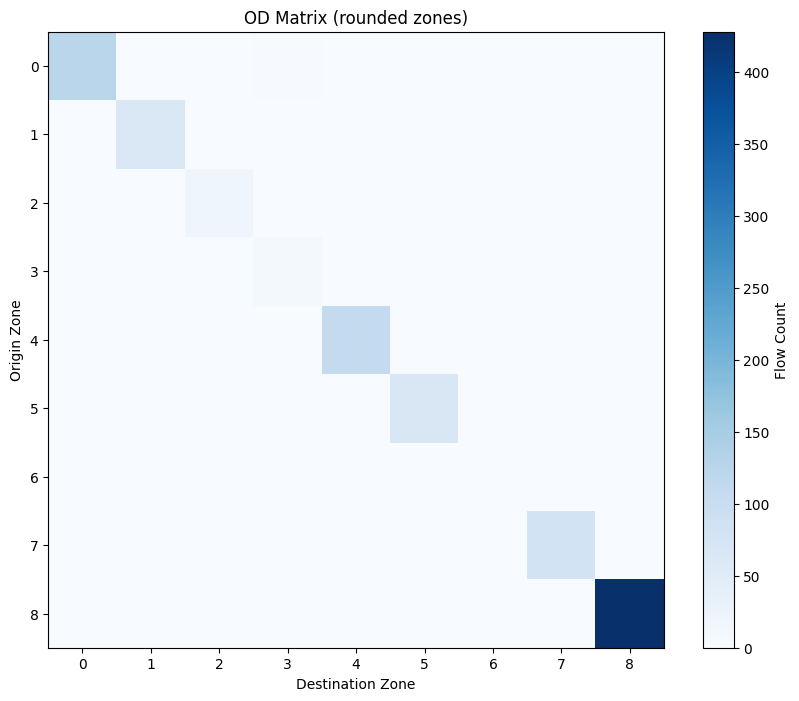

In [29]:
#OD行列でヒートマップとして可視化
# ピボットして OD マトリクスに変換
od_matrix = od_pairs.pivot(index='zone', columns='zone_next', values='count').fillna(0)

plt.figure(figsize=(10, 8))
plt.imshow(od_matrix, cmap='Blues')
plt.colorbar(label='Flow Count')
plt.title('OD Matrix (rounded zones)')
plt.xlabel('Destination Zone')
plt.ylabel('Origin Zone')
plt.show()

In [30]:
#ODの上位パターンを表にする
od_pairs.sort_values('count', ascending=False).head(10)

,zone,zone_next,count
18,"(40.01, 116.32)","(40.01, 116.32)",428
0,"(39.98, 116.3)","(39.98, 116.3)",123
10,"(39.99, 116.31)","(39.99, 116.31)",110
16,"(40.0, 116.32)","(40.0, 116.32)",79
12,"(39.99, 116.32)","(39.99, 116.32)",65
4,"(39.98, 116.31)","(39.98, 116.31)",62
6,"(39.98, 116.32)","(39.98, 116.32)",19
8,"(39.99, 116.3)","(39.99, 116.3)",9
1,"(39.98, 116.3)","(39.99, 116.3)",2
2,"(39.98, 116.3)","(40.0, 116.29)",1


In [8]:
#滞留点分析の準備
#距離（haversine）関数
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    2点間のハバーサイン距離（メートル）を返す
    """
    R = 6371000  # 地球半径 [m]
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1) * cos(phi2) * sin(dlambda/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

In [9]:
#滞留点検出アルゴリズム
def detect_stay_points(df, dist_thresh=200, time_thresh_minutes=10):
    """
    滞留点検出（シンプル版）

    Parameters
    ----------
    df : DataFrame
        カラム: ['lat', 'lon', 'datetime'] を想定（時系列ソート済み）
    dist_thresh : float
        滞留とみなす最大半径 [m]
    time_thresh_minutes : float
        滞留とみなす最小滞在時間 [分]

    Returns
    -------
    stays : DataFrame
        カラム: ['lat', 'lon', 'arrival_time', 'leave_time', 'duration_min']
    """
    df = df.sort_values('datetime').reset_index(drop=True)
    n = len(df)
    stays = []

    i = 0
    while i < n - 1:
        j = i + 1
        while j < n:
            dist = haversine_distance(
                df.loc[i, 'lat'], df.loc[i, 'lon'],
                df.loc[j, 'lat'], df.loc[j, 'lon']
            )
            if dist > dist_thresh:
                # i から j-1 までの滞在時間を確認
                delta_t = (df.loc[j-1, 'datetime'] - df.loc[i, 'datetime']).total_seconds() / 60.0
                if delta_t >= time_thresh_minutes:
                    # 滞在点として登録（i..j-1の平均位置）
                    lat_mean = df.loc[i:j-1, 'lat'].mean()
                    lon_mean = df.loc[i:j-1, 'lon'].mean()
                    arrival_time = df.loc[i, 'datetime']
                    leave_time = df.loc[j-1, 'datetime']

                    stays.append({
                        'lat': lat_mean,
                        'lon': lon_mean,
                        'arrival_time': arrival_time,
                        'leave_time': leave_time,
                        'duration_min': delta_t
                    })
                # 次の候補へ
                i = j
                break
            else:
                j += 1

        # 末尾まで到達した場合の処理
        if j >= n:
            break

    return pd.DataFrame(stays)

In [10]:
#実行例

# df: GeoLife PLT から読み込んだ DataFrame
# カラム: ['lat', 'lon', 'datetime']

stays = detect_stay_points(df, dist_thresh=200, time_thresh_minutes=10)
stays.head()

,lat,lon,arrival_time,leave_time,duration_min
0,40.008642,116.321018,2008-10-23 09:44:50,2008-10-23 10:09:11,24.350000
1,40.007729,116.319257,2008-10-23 10:09:16,2008-10-23 10:31:20,22.066667
2,40.008881,116.322081,2008-10-23 10:44:31,2008-10-23 11:10:37,26.100000


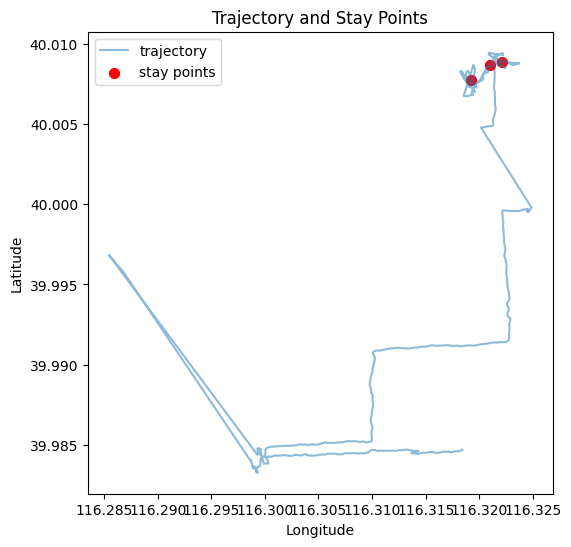

In [11]:
#軌跡と滞留点を matplotlib で可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# 軌跡（線）
plt.plot(df['lon'], df['lat'], '-', alpha=0.5, label='trajectory')

# 滞留点（点）
if not stays.empty:
    plt.scatter(stays['lon'], stays['lat'], c='red', s=50, label='stay points')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Trajectory and Stay Points')
plt.show()

In [ ]:
##foliumによる可視化

In [12]:
!pip install folium

In [13]:
import pandas as pd
from pathlib import Path

def read_geolife_plt(path):
    cols = ['lat', 'lon', 'unused', 'alt', 'days', 'date', 'time']
    df = pd.read_csv(path, skiprows=6, header=None, names=cols)
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])

    return df[['lat', 'lon', 'datetime']]

In [14]:
import folium

def plot_trajectory_folium(df, zoom_start=14):
    # 中心（最初の点）
    center = [df['lat'].iloc[0], df['lon'].iloc[0]]

    m = folium.Map(location=center, zoom_start=zoom_start)

    # 線の座標リスト（lat, lon の順）
    coords = df[['lat', 'lon']].values.tolist()

    folium.PolyLine(coords, color="blue", weight=4, opacity=0.7).add_to(m)

    # 開始点と終了点
    folium.Marker(coords[0], tooltip="Start").add_to(m)
    folium.Marker(coords[-1], tooltip="End").add_to(m)

    return m

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

path = "/content/drive/MyDrive/Geolife Trajectories 1.3/Data/000/Trajectory/20090625041631.plt"
df = read_geolife_plt(path)

m = plot_trajectory_folium(df)
m

In [16]:
from math import radians, sin, cos, sqrt, atan2
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1-a))

def detect_stay_points(df, dist_thresh=200, time_thresh_minutes=10):
    df = df.sort_values('datetime').reset_index(drop=True)
    stays = []
    i = 0
    n = len(df)

    while i < n - 1:
        j = i + 1
        while j < n:
            dist = haversine_distance(df.loc[i,'lat'], df.loc[i,'lon'],
                                      df.loc[j,'lat'], df.loc[j,'lon'])
            if dist > dist_thresh:
                delta_t = (df.loc[j-1,'datetime'] - df.loc[i,'datetime']).total_seconds() / 60
                if delta_t >= time_thresh_minutes:
                    stays.append({
                        'lat': df.loc[i:j-1,'lat'].mean(),
                        'lon': df.loc[i:j-1,'lon'].mean(),
                        'duration_min': delta_t,
                        'arrival_time': df.loc[i,'datetime'],
                        'leave_time': df.loc[j-1,'datetime']
                    })
                i = j
                break
            j += 1
        if j >= n:
            break
    return pd.DataFrame(stays)

In [17]:
def plot_staypoints_folium(df, stays, zoom_start=14):
    center = [df['lat'].iloc[0], df['lon'].iloc[0]]
    m = folium.Map(location=center, zoom_start=zoom_start)

    # 軌跡
    coords = df[['lat', 'lon']].values.tolist()
    folium.PolyLine(coords, color="blue", weight=3).add_to(m)

    # 滞留点
    for _, row in stays.iterrows():
        popup = f"Stay {row['duration_min']:.1f} min<br>{row['arrival_time']} → {row['leave_time']}"
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=6,
            color="red",
            fill=True,
            fill_color="red",
            popup=popup
        ).add_to(m)

    return m

In [18]:
stays = detect_stay_points(df, dist_thresh=200, time_thresh_minutes=10)
m2 = plot_staypoints_folium(df, stays)
m2

In [ ]:
#(追加)ゾーンの可視化

In [1]:
import folium
import numpy as np

def make_zone_map(df, n_rows=4, n_cols=4, margin=0.001, zoom_start=14):
    """
    緯度経度の散布範囲を n_rows × n_cols に分割し、
    Folium 上にゾーン（矩形）として描画する。

    Parameters
    ----------
    df : pandas.DataFrame
        'lat', 'lon' 列を含むデータフレーム
    n_rows, n_cols : int
        ゾーンの行数・列数
    margin : float
        範囲の周囲に少し余白を持たせる度数（約 0.001 ≒ 100m 弱）
    zoom_start : int
        Folium 地図の初期ズーム

    Returns
    -------
    m : folium.Map
        ゾーンを描画した Folium マップ
    """

    # 範囲を取得
    lat_min, lat_max = df['lat'].min(), df['lat'].max()
    lon_min, lon_max = df['lon'].min(), df['lon'].max()

    # 少し余白を付ける
    lat_min -= margin
    lat_max += margin
    lon_min -= margin
    lon_max += margin

    # 分割線（格子の境界）を決める
    lat_edges = np.linspace(lat_min, lat_max, n_rows + 1)
    lon_edges = np.linspace(lon_min, lon_max, n_cols + 1)

    # 地図の中心
    center = [df['lat'].mean(), df['lon'].mean()]
    m = folium.Map(location=center, zoom_start=zoom_start)

    # まず軌跡も描きたい場合（任意）
    coords = df[['lat', 'lon']].values.tolist()
    folium.PolyLine(coords, color="blue", weight=3, opacity=0.7).add_to(m)

    # 各ゾーンを矩形として描画
    zone_id = 0
    for i in range(n_rows):
        for j in range(n_cols):
            lat1, lat2 = lat_edges[i], lat_edges[i+1]
            lon1, lon2 = lon_edges[j], lon_edges[j+1]

            # 矩形の四隅（左下→左上→右上→右下）
            bounds = [[lat1, lon1],
                      [lat2, lon1],
                      [lat2, lon2],
                      [lat1, lon2]]

            zid = f"Z{i}_{j}"  # ゾーンID（行・列）

            folium.Polygon(
                locations=bounds,
                color="red",
                weight=1,
                fill=False,
                popup=f"Zone {zid}"
            ).add_to(m)

            # ゾーンの中心にラベルを置きたい場合
            lat_c = (lat1 + lat2) / 2
            lon_c = (lon1 + lon2) / 2
            folium.Marker(
                location=[lat_c, lon_c],
                icon=folium.DivIcon(
                    html=f'<div style="font-size:10pt; color:black;">{zid}</div>'
                )
            ).add_to(m)

            zone_id += 1

    return m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# 例: GeoLife の PLT を読み込み
path = "/content/drive/MyDrive/Geolife Trajectories 1.3/Data/000/Trajectory/20090628005229.plt"

import pandas as pd

def read_geolife_plt(path):
    cols = ['lat','lon','unused','alt','days','date','time']
    df = pd.read_csv(path, skiprows=6, header=None, names=cols)
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
    return df[['lat','lon','datetime']]

df = read_geolife_plt(path)

# ゾーンを 4×4 に分割して描画
m = make_zone_map(df, n_rows=4, n_cols=4, margin=0.001, zoom_start=14)
m  # Colab上で地図がインラインで表示される

Mounted at /content/drive
